# **Fine-Grained Image Classification with the CUB-200-2011 Dataset**

In this notebook, the [ConvNeXt V2 Large](https://huggingface.co/facebook/convnextv2-large-22k-384) model is fine-tuned using the [CUB-200-2011](https://www.vision.caltech.edu/datasets/cub_200_2011/) dataset for the task of fine-grained image classification. This type of classification is a more specialized and challenging extension of conventional image classification, focused on distinguishing between classes that are visually very similar. For example, differentiating between various dog breeds or different bird species, where the differences between classes are subtle, making the task more challenging.

The CUB-200-2011 dataset contains 11,788 RGB images, with 5,994 images designated for training and 5,794 for testing, distributed across 200 different bird species. The challenge is further heightened due to the relatively small training dataset, which makes it more difficult for the model to generalize effectively across so many classes.

The [ConvNeXt V2](https://huggingface.co/docs/transformers/model_doc/convnextv2) model is a pure convolutional neural network, pretrained using the FCMAE (Fully Convolutional Masked Autoencoder) framework. This framework is a convolutional-based approach for masked autoencoders (MAE), a mechanism typically using Transformer architectures. In MAE, a significant portion of the input (images) is masked during training, and the model learns to reconstruct the missing parts from the visible information, forcing the model to capture robust and generalizable features.

Additionally, ConvNeXt V2 introduces an extra layer called Global Response Normalization (GRN) to the original [ConvNeXt](https://huggingface.co/docs/transformers/model_doc/convnext) architecture. This layer helps improve the consistency and stability of the model's output by normalizing the response of neurons across the entire image, allowing for better generalization in complex computer vision tasks. The model has been fine-tuned with the [ImageNet-22K](https://www.image-net.org/) dataset at a resolution of 384x384 pixels, providing a solid foundation for high-precision classification tasks.


## **Imports**

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
from transformers import AutoImageProcessor, TFAutoModelForImageClassification
from transformers import create_optimizer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from google.colab import drive
import os

## **Parameters**

In [ ]:
drive.mount("/content/drive/")

Mounted at /content/drive/


In [ ]:
epochs = 7
batch_size = 16
buffer_size = 1024
AUTOTUNE = tf.data.AUTOTUNE
SEED = 123
model_name = "facebook/convnextv2-large-22k-384"

## **Prepare the dataset for training**

### **Load the dataset**

When downloading the CUB-200-2011 dataset, also known as Caltech Birds 2011, through TensorFlow Datasets, a `NonMatchingChecksumError` occurs, likely due to issues with Google Drive where the dataset is hosted. To resolve this, the dataset is manually downloaded from the official Caltech Vision Lab website, and the images and labels are properly prepared using the Pandas library.

In [ ]:
try:
   (train_dataset, test_dataset), info = tfds.load("caltech_birds2011", split=["train", "test"], as_supervised=True, with_info=True)
except Exception as error:
  print(f"Error: {error}")

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Error: Artifact https://drive.google.com/uc?export=download&id=1hbzc_P1FuxMkcabkgn9ZKinBwW683j45, downloaded to /root/tensorflow_datasets/downloads/ucexport_download_id_1hbzc_P1FuxMkcabkgn9ZKinBw1sbZS_7v82APqMiPk0wej8WzZ5MmtVy61NUy-F6708.tmp.ed420b2e8a9d47c4a9270766b7bd6c04/download, has wrong checksum:
* Expected: UrlInfo(size=1.07 GiB, checksum='0c685df5597a8b24909f6a7c9db6d11e008733779a671760afef78feb49bf081', filename='CUB_200_2011.tgz')
* Got: UrlInfo(size=2.37 KiB, checksum='48c34f9a2078ad513d47d9849d8df3d0fa17b70112e8c958fafc06e6837c75e9', filename='download')
To debug, see: https://www.tensorflow.org/datasets/overview#fixing_nonmatchingchecksumerror


In [ ]:
# Download and extract the dataset
url_data = "https://data.caltech.edu/records/65de6-vp158/files/CUB_200_2011.tgz?download=1"
path_data = tf.keras.utils.get_file(origin=url_data, cache_subdir="/content/", extract=True)
path_data = path_data.split(".")[0]
path_data

1150585339/1150585339 [==============================] - 82s 0us/step


'/content/CUB_200_2011'

In [ ]:
!ls $path_data

attributes	    classes.txt		    images	parts	train_test_split.txt
bounding_boxes.txt  image_class_labels.txt  images.txt	README


In [ ]:
# Create a DataFrame by merging the necessary files for the images, labels, and dataset split
df_image = pd.read_csv(os.path.join(path_data, "images.txt"), sep=" ", header=None, names=["id", "image"])
df_label = pd.read_csv(os.path.join(path_data, "image_class_labels.txt"), sep=" ", header=None, names=["id", "label"])
df_split = pd.read_csv(os.path.join(path_data, "train_test_split.txt"), sep=" ", header=None, names=["id", "split"])

# In this case, it is also possible to merge the files of interest using pd.concat, as they all have the same number of records
#df = pd.concat([df_image, df_label, df_split], axis=1)
df_data = pd.merge(df_image, df_label, on="id", how="inner")
df_data = pd.merge(df_data, df_split, on="id", how="inner")

# Shuffle the DataFrame records
df_data = df_data.sample(frac=1, random_state=SEED).reset_index(drop=True)

# Normalize the image paths
df_data["image"] = df_data.image.apply(lambda x: os.path.join(path_data, f"images/{x}"))

# The labels need to start with index 0
df_data["label"] = df_data.label - 1

del df_image, df_label, df_split #Delete the unnecessary DataFrames to free up storage space
df_data

id                                              image  label  split
0       9180  /content/CUB_200_2011/images/157.Yellow_throat...    156      0
1      11076  /content/CUB_200_2011/images/189.Red_bellied_W...    188      1
2       6341  /content/CUB_200_2011/images/109.American_Reds...    108      0
3         98  /content/CUB_200_2011/images/002.Laysan_Albatr...      1      0
4       8621  /content/CUB_200_2011/images/147.Least_Tern/Le...    146      1
...      ...                                                ...    ...    ...
11783   7764  /content/CUB_200_2011/images/133.White_throate...    132      1
11784   5219  /content/CUB_200_2011/images/090.Red_breasted_...     89      0
11785   1347  /content/CUB_200_2011/images/025.Pelagic_Cormo...     24      0
11786  11647  /content/CUB_200_2011/images/198.Rock_Wren/Roc...    197      1
11787   3583  /content/CUB_200_2011/images/062.Herring_Gull/...     61      1

[11788 rows x 4 columns]

In [ ]:
# There are no null values
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11788 entries, 0 to 11787
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      11788 non-null  int64 
 1   image   11788 non-null  object
 2   label   11788 non-null  int64 
 3   split   11788 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 368.5+ KB


In [ ]:
val_counts = df_data[df_data.split == 1].label.value_counts().sort_values()
val_counts

label
125    29
140    29
195    29
134    29
189    29
       ..
197    30
154    30
67     30
156    30
148    30
Name: count, Length: 200, dtype: int64

In [ ]:
val_counts[val_counts == 29].count()

6

It can be observed that the training dataset (``split=1``) is nearly balanced. All classes have exactly 30 images, except for 6 classes that have 29 images, so there is no need to apply oversampling techniques.

In [ ]:
# Find the class names and the number of classes
class_names = pd.read_csv(os.path.join(path_data, "classes.txt"), sep=" ", header=None, names=["id", "name"])
class_names = class_names.sort_values(by="id")
class_names["name"] = class_names.name.apply(lambda x: x.split(".")[1])
class_names["name"] = class_names.name.apply(lambda x: " ".join(x.split("_")))

class_names = class_names.name.tolist()
num_classes = len(class_names)

print("Number of classes:", num_classes)
print("Class names:", class_names)

Number of classes: 200
Class names: ['Black footed Albatross', 'Laysan Albatross', 'Sooty Albatross', 'Groove billed Ani', 'Crested Auklet', 'Least Auklet', 'Parakeet Auklet', 'Rhinoceros Auklet', 'Brewer Blackbird', 'Red winged Blackbird', 'Rusty Blackbird', 'Yellow headed Blackbird', 'Bobolink', 'Indigo Bunting', 'Lazuli Bunting', 'Painted Bunting', 'Cardinal', 'Spotted Catbird', 'Gray Catbird', 'Yellow breasted Chat', 'Eastern Towhee', 'Chuck will Widow', 'Brandt Cormorant', 'Red faced Cormorant', 'Pelagic Cormorant', 'Bronzed Cowbird', 'Shiny Cowbird', 'Brown Creeper', 'American Crow', 'Fish Crow', 'Black billed Cuckoo', 'Mangrove Cuckoo', 'Yellow billed Cuckoo', 'Gray crowned Rosy Finch', 'Purple Finch', 'Northern Flicker', 'Acadian Flycatcher', 'Great Crested Flycatcher', 'Least Flycatcher', 'Olive sided Flycatcher', 'Scissor tailed Flycatcher', 'Vermilion Flycatcher', 'Yellow bellied Flycatcher', 'Frigatebird', 'Northern Fulmar', 'Gadwall', 'American Goldfinch', 'European Goldfi

In [ ]:
# Create the training and testing datasets
train_dataset = tf.data.Dataset.from_tensor_slices(
    (df_data[df_data.split == 1].image.values, df_data[df_data.split == 1].label.values)
)

test_dataset = tf.data.Dataset.from_tensor_slices(
    (df_data[df_data.split == 0].image.values, df_data[df_data.split == 0].label.values)
)

del df_data
len(train_dataset), len(test_dataset)

(5994, 5794)

In [ ]:
# View an example from the training dataset
for image, label in train_dataset.take(1):
  print(image)
  print(label)

tf.Tensor(b'/content/CUB_200_2011/images/189.Red_bellied_Woodpecker/Red_Bellied_Woodpecker_0050_180751.jpg', shape=(), dtype=string)
tf.Tensor(188, shape=(), dtype=int64)


### **Preprocessing and data augmentation**

To combat overfitting, it is crucial to use data augmentation techniques due to the small size of the training dataset. Data augmentation will help improve the model's generalization capability for fine-grained image classification. To achieve this, TensorFlow layers such as [``RandomFlip``](https://www.tensorflow.org/api_docs/python/tf/keras/layers/RandomFlip), [``RandomTranslation``](https://www.tensorflow.org/api_docs/python/tf/keras/layers/RandomTranslation), [``RandomRotation``](https://www.tensorflow.org/api_docs/python/tf/keras/layers/RandomRotation), and [``RandomZoom``](https://www.tensorflow.org/api_docs/python/tf/keras/layers/RandomZoom) will be used. These layers should only be applied to the training dataset, which is controlled by setting the ``training=True`` parameter.

Regarding image preprocessing, each image path is converted into TensorFlow tensors using the ``preprocessing`` function, which also standardizes their size to be compatible with the model. This preprocessing is applied to both the training and testing datasets. Additionally, the following TensorFlow layers will be used for preprocessing: the [``Rescaling``](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Rescaling) layer to normalize images in the range of ``[-1, 1]``, and the [``Permute``](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Permute) layer to rearrange image channels in the second dimension, ensuring compatibility with the PyTorch model format. These two layers operate independently of the ``training`` parameter, so they are applied to both the training and testing datasets.

It is also worth noting that preprocessing could be done using the generic image processor class from Hugging Face, [AutoImageProcessor](https://huggingface.co/docs/transformers/model_doc/auto#transformers.AutoImageProcessor). However, this option is not compatible with TensorFlow graphs, which could slow down training.

In [ ]:
image_processor = AutoImageProcessor.from_pretrained(model_name)
image_processor

ConvNextImageProcessor {
  "crop_pct": 0.875,
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.485,
    0.456,
    0.406
  ],
  "image_processor_type": "ConvNextImageProcessor",
  "image_std": [
    0.229,
    0.224,
    0.225
  ],
  "resample": 3,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "shortest_edge": 384
  }
}

In [ ]:
original_size = (None, None, 3)
new_size = (image_processor.size["shortest_edge"], image_processor.size["shortest_edge"], 3)

original_size, new_size

((None, None, 3), (384, 384, 3))

In [ ]:
def preprocessing(path, label):
  image = tf.io.read_file(path)
  image = tf.image.decode_jpeg(image, channels=3)
  image = tf.image.resize(image, new_size[:-1])
  return image, label

In [ ]:
def function_data_augmentation(input_shape):
  return tf.keras.Sequential([
      tf.keras.Input(shape=input_shape),
      tf.keras.layers.RandomFlip("horizontal"),
      tf.keras.layers.RandomTranslation(height_factor=0.2, width_factor=0.2, fill_mode="nearest"),
      tf.keras.layers.RandomRotation(0.1, fill_mode="nearest"),
      tf.keras.layers.RandomZoom(0.2, fill_mode="nearest"),
      tf.keras.layers.Rescaling(1/127.5, offset=-1),
      tf.keras.layers.Permute((3, 1, 2))
  ], name="data_augmentation")

In [ ]:
tf.keras.backend.clear_session() #Clearing Keras memory

data_augmentation = function_data_augmentation(new_size)
data_augmentation.summary()

Model: "data_augmentation"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip (RandomFlip)    (None, 384, 384, 3)       0         
                                                                 
 random_translation (Random  (None, 384, 384, 3)       0         
 Translation)                                                    
                                                                 
 random_rotation (RandomRot  (None, 384, 384, 3)       0         
 ation)                                                          
                                                                 
 random_zoom (RandomZoom)    (None, 384, 384, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 384, 384, 3)       0         
                                                                 
 permute (Permute)           (None, 3, 384, 384) 

In [ ]:
def prepare_dataset(dataset, training=True):
  dataset = dataset.map(preprocessing, num_parallel_calls=AUTOTUNE)

  if training:
    dataset = dataset.shuffle(buffer_size, seed=SEED)

  dataset = (
      dataset.
      batch(batch_size).
      map(lambda x, y : (data_augmentation(x, training=training), y), num_parallel_calls=AUTOTUNE).
      prefetch(AUTOTUNE)
  )

  return dataset

In [ ]:
train_dataset = prepare_dataset(train_dataset)
test_dataset = prepare_dataset(test_dataset, training=False)

In [ ]:
# Take a batch from the training dataset
for images, labels in train_dataset.take(1):
  print(images.shape, labels.shape)

images.numpy().min(), images.numpy().max()

(16, 3, 384, 384) (16,)


(-1.0, 1.0)

**Function to display and save images**

In [ ]:
def show_images(images, labels, predictions=None, num_examples=16, random=True,
                cmap=None, axis="off", save=False, path=""):

  # Denormalize the images
  images = (tf.transpose(images, perm=[0, 2, 3, 1]) + 1) / 2

  n = int(np.sqrt(num_examples))
  indices = np.arange(len(images))
  if random:
    np.random.shuffle(indices)

  fig, axes = plt.subplots(n, n, figsize=(1.9*n, 1.9*n))

  for i, ax in enumerate(axes.flat):
    ax.imshow(images[indices[i]], cmap=cmap)

    if predictions is not None:
      color = "#00008B" if labels[indices[i]] == predictions[indices[i]] else "red"

      ax.text(
          x=0.5, y=1.101, s=f"Label: {class_names[labels[indices[i]]]}", color=color, fontsize=6.9,
          fontweight="bold", ha="center", va="bottom", transform=ax.transAxes
      )
      ax.text(
          x=0.5, y=1, s=f"Pred: {class_names[predictions[indices[i]]]}", color=color, fontsize=6.9,
          fontweight="bold", ha="center", va="bottom", transform=ax.transAxes
      )

    else:
      ax.text(
          x=0.5, y=1, s=f"Label: {class_names[labels[indices[i]]]}", fontsize=6.9,
          fontweight="bold", ha="center", va="bottom", transform=ax.transAxes
      )

    ax.axis(axis)

  plt.tight_layout()
  # Save images
  if save:
    plt.savefig(path)

  plt.show()

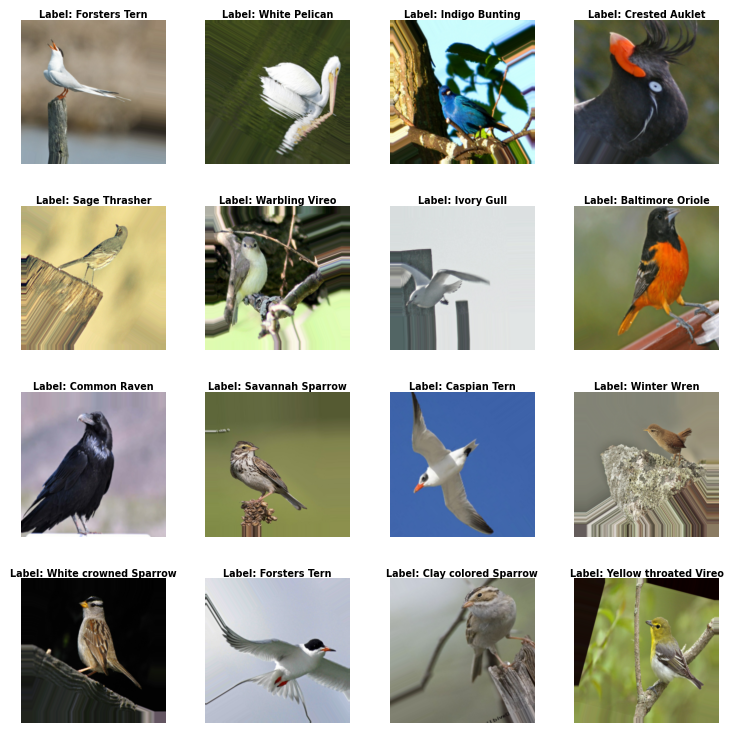

In [ ]:
# Some images from the training dataset after data augmentation
show_images(images, labels, random=False)

## **Model building and training**

To speed up the training time, Google's Colab TPU is used due to the large size of the model, which has about 200 million parameters. The model is loaded using the generic class [TFAutoModelForImageClassification](https://huggingface.co/docs/transformers/model_doc/auto#transformers.AutoModelForImageClassification), which allows for the loading of a ViT model available on Hugging Face by specifying only its name.

In [ ]:
# TPU setup

try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver(tpu="local")
  tf.config.experimental_connect_to_cluster(tpu)
  tf.tpu.experimental.initialize_tpu_system(tpu)
  strategy = tf.distribute.TPUStrategy(tpu)
  print("TPU initialized:")
  print("All devices: ", tf.config.list_logical_devices("TPU"))
except (ValueError, tf.errors.InvalidArgumentError, tf.errors.NotFoundError) as error:
  print(f"Error: {error}")

TPU initialized:
All devices:  [LogicalDevice(name='/device:TPU:0', device_type='TPU'), LogicalDevice(name='/device:TPU:1', device_type='TPU'), LogicalDevice(name='/device:TPU:2', device_type='TPU'), LogicalDevice(name='/device:TPU:3', device_type='TPU'), LogicalDevice(name='/device:TPU:4', device_type='TPU'), LogicalDevice(name='/device:TPU:5', device_type='TPU'), LogicalDevice(name='/device:TPU:6', device_type='TPU'), LogicalDevice(name='/device:TPU:7', device_type='TPU')]


In [ ]:
tf.keras.backend.clear_session()

with strategy.scope():
  model = TFAutoModelForImageClassification.from_pretrained(
      model_name,
      num_labels=num_classes,
      ignore_mismatched_sizes=True
  )

  optimizer, lr_schedule = create_optimizer(
      init_lr=3e-5,
      num_train_steps=len(train_dataset)*epochs,
      weight_decay_rate=0.01,
      num_warmup_steps=0
  )
  model.compile(
      optimizer=optimizer,
      loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
      metrics=[tf.keras.metrics.SparseCategoricalAccuracy(name="accuracy")],
      steps_per_execution=50
  )

model.summary()

All model checkpoint layers were used when initializing TFConvNextV2ForImageClassification.

Some weights of TFConvNextV2ForImageClassification were not initialized from the model checkpoint at facebook/convnextv2-large-22k-384 and are newly initialized because the shapes did not match:
- classifier/kernel:0: found shape (1536, 1000) in the checkpoint and (1536, 200) in the model instantiated
- classifier/bias:0: found shape (1000,) in the checkpoint and (200,) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: "tf_conv_next_v2_for_image_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 convnextv2 (TFConvNextV2Ma  multiple                  196419840 
 inLayer)                                                        
                                                                 
 classifier (Dense)          multiple                  307400    
                                                                 
Total params: 196727240 (750.45 MB)
Trainable params: 196727240 (750.45 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# Callback to stop training early if validation accuracy does not improve for 1 epoch
patience = 1
callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_accuracy",
    patience=patience,
    restore_best_weights=True
)

In [ ]:
# Train the model
history = model.fit(train_dataset, epochs=epochs, validation_data=test_dataset, callbacks=[callback])

Epoch 1/7
375/375 [==============================] - 517s 1s/step - loss: 2.3342 - accuracy: 0.5677 - val_loss: 0.6767 - val_accuracy: 0.8271
Epoch 2/7
375/375 [==============================] - 108s 288ms/step - loss: 0.4974 - accuracy: 0.8709 - val_loss: 0.4617 - val_accuracy: 0.8778
Epoch 3/7
375/375 [==============================] - 108s 288ms/step - loss: 0.2792 - accuracy: 0.9264 - val_loss: 0.4206 - val_accuracy: 0.8902
Epoch 4/7
375/375 [==============================] - 108s 287ms/step - loss: 0.1719 - accuracy: 0.9576 - val_loss: 0.3966 - val_accuracy: 0.9002
Epoch 5/7
375/375 [==============================] - 108s 287ms/step - loss: 0.1060 - accuracy: 0.9778 - val_loss: 0.3658 - val_accuracy: 0.9128
Epoch 6/7
375/375 [==============================] - 108s 287ms/step - loss: 0.0691 - accuracy: 0.9872 - val_loss: 0.3676 - val_accuracy: 0.9140
Epoch 7/7
375/375 [==============================] - 107s 286ms/step - loss: 0.0516 - accuracy: 0.9925 - val_loss: 0.3599 - val_accur

**Save the model**

In [ ]:
trained_model_path = "/content/drive/MyDrive/models/Fine-Grained_ImageClassification_ConvNeXTV2_CUB-200-2011"
model.save_pretrained(trained_model_path)

## **Model Evaluation**

In [ ]:
print(model.evaluate(train_dataset, verbose=0))
print(model.evaluate(test_dataset, verbose=0))

[0.04371006786823273, 0.9954954981803894]
[0.3598775267601013, 0.9164652824401855]


### **Graphs of the metrics**

In [ ]:
# Library needed to convert Plotly interactive graphics into images
!pip install kaleido -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 12.2 MB/s eta 0:00:00


In [ ]:
# Function to plot the metrics
def plot_metrics(history=history.history, metric="loss", renderer=None, with_patience=False):
  epochs = len(history["loss"])
  losses = history[metric]
  val_losses = history[f"val_{metric}"]
  list_epochs = np.arange(1, epochs+1)
  metric = " ".join([w.capitalize() for w in metric.split("_")])

  fig=go.Figure()
  fig.add_trace(go.Scatter(x=list_epochs, y=losses, name=metric, line=dict(color="blue", width=2)))
  fig.add_trace(go.Scatter(x=list_epochs, y=val_losses, name=f"Val {metric}", line=dict(color="#FF6600", width=2)))

  last_epoch = epochs-patience if with_patience else epochs
  fig.add_vline(
      x=last_epoch, line=dict(color="red", width=2, dash="dash"),
      annotation_text="End of Training", annotation_position="top left",
      annotation=dict(font_size=12, font_color="red")
  )

  fig.update_xaxes(title_text="Epoch")
  fig.update_yaxes(title_text=metric)
  fig.update_layout(title=f"Evolution of {metric} across Epochs",
                    title_font=dict(size=20),
                    title_x=0.5,
                    height=500,
                    width=1200)

  fig.show(renderer)

In [ ]:
# Interactive graphic
plot_metrics(metric="accuracy")
plot_metrics()

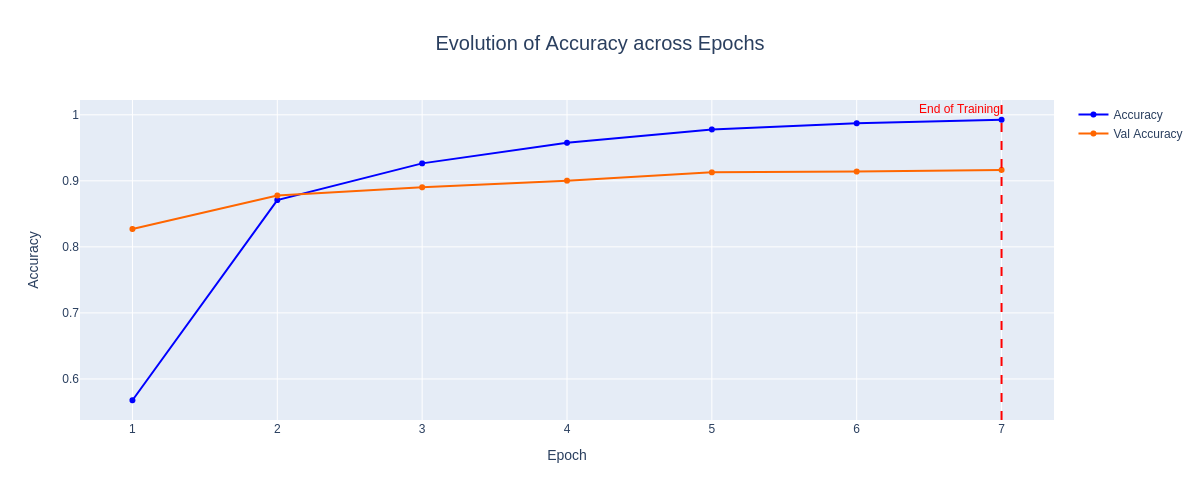

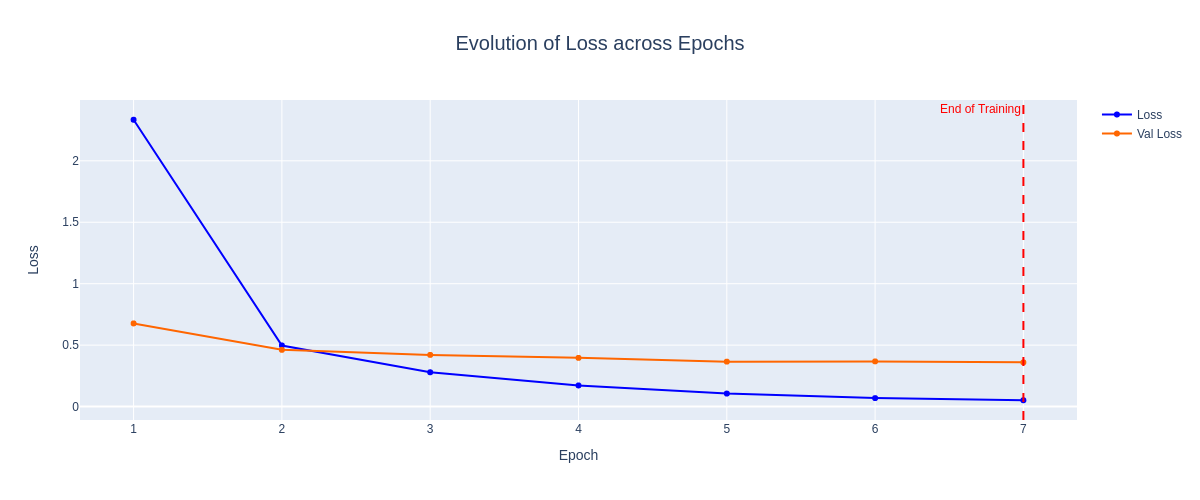

In [ ]:
# Static image for GitHub
plot_metrics(metric="accuracy", renderer="png")
plot_metrics(renderer="png")

### **Confusion Matrix**

In [ ]:
# Extract labels from the test dataset
labels_test = test_dataset.unbatch().map(lambda image, label: label)
labels_test = np.array(list(labels_test.as_numpy_iterator()))

# Generate predictions with the trained model
labels_test_pred = model.predict(test_dataset, verbose=0).logits
labels_test_pred = np.argmax(labels_test_pred, axis=-1)

# Consolidating the accuracy of the test dataset
print("Accuracy:", np.mean(labels_test == labels_test_pred))
print(f"F1 Score: {f1_score(labels_test, labels_test_pred, average='macro')}")

Accuracy: 0.9164652824401855
F1 Score: 0.9156547123581877


In [ ]:
cm = confusion_matrix(labels_test, labels_test_pred)
cmd = ConfusionMatrixDisplay(cm, display_labels=class_names)
fig, ax = plt.subplots(figsize=(35, 35))
cmd.plot(ax=ax, colorbar=False, cmap="coolwarm_r", xticks_rotation="vertical")

for text in ax.texts:
  text.set_fontsize(9)

ax.tick_params(axis="x", labelsize=8)
ax.tick_params(axis="y", labelsize=8)
plt.tight_layout()
fig.savefig("ConfusionMatrix_ConvNeXTV2_CUB-200-2011.svg", format="svg")
plt.close()

Since the dataset contains many classes (200 in total), the confusion matrix does not display optimally within this notebook. Therefore, it is saved in SVG format for clear visualization in a web browser via the following [**link**](https://raw.githubusercontent.com/JersonGB22/ImageClassification-TensorFlow/main/images/images_models/ConfusionMatrix_ConvNeXTV2_CUB-200-2011.svg). Additionally, evaluation results are presented in a Pandas DataFrame to provide a more detailed and clear view.

In [ ]:
# Create the DataFrame with the most relevant variables for analysis
frequency = np.unique(labels_test, return_counts=True)[1]
correct_predictions = np.diag(cm)

df = pd.DataFrame({
    "Class": class_names,
    "Frequency": frequency,
    "Correct Predictions": correct_predictions,
    "Accuracy (%)": [round(per*100, 2) for per in correct_predictions/frequency]
})

# Sort the DataFrame in descending order according to accuracy
df = df.sort_values(by="Accuracy (%)", ascending=False)
#df

View the evaluation results of the test dataset by dividing the DataFrame into 4 parts to enhance clarity:

In [ ]:
df.iloc[:50]

Class  Frequency  Correct Predictions  Accuracy (%)
16                      Cardinal         27                   27         100.0
6                Parakeet Auklet         23                   23         100.0
11       Yellow headed Blackbird         26                   26         100.0
105                Horned Puffin         30                   30         100.0
108            American Redstart         30                   30         100.0
89        Red breasted Merganser         30                   30         100.0
90                   Mockingbird         30                   30         100.0
92              Clark Nutcracker         30                   30         100.0
93       White breasted Nuthatch         30                   30         100.0
19          Yellow breasted Chat         29                   29         100.0
20                Eastern Towhee         30                   30         100.0
27                 Brown Creeper         29                   29         100.0
33       Gray crowned Rosy Finch         29                   29         100.0
34                  Purple Finch         30                   30         100.0
35              Northern Flicker         30                   30         100.0
109                    Geococcyx         30                   30         100.0
113       Black throated Sparrow         30                   30         100.0
148               Brown Thrasher         29                   29         100.0
150           Black capped Vireo         21                   21         100.0
99                 Brown Pelican         30                   30         100.0
100                White Pelican         20                   20         100.0
39        Olive sided Flycatcher         30                   30         100.0
168             Magnolia Warbler         29                   29         100.0
78             Belted Kingfisher         30                   30         100.0
82     White breasted Kingfisher         30                   30         100.0
83          Red legged Kittiwake         23                   23         100.0
84                   Horned Lark         30                   30         100.0
85                  Pacific Loon         30                   30         100.0
87            Western Meadowlark         30                   30         100.0
40     Scissor tailed Flycatcher         30                   30         100.0
41          Vermilion Flycatcher         30                   30         100.0
43                   Frigatebird         30                   30         100.0
45                       Gadwall         30                   30         100.0
46            American Goldfinch         30                   30         100.0
47            European Goldfinch         30                   30         100.0
158      Black and white Warbler         30                   30         100.0
159  Black throated Blue Warbler         29                   29         100.0
73                   Florida Jay         30                   30         100.0
74                     Green Jay         27                   27         100.0
75               Dark eyed Junco         30                   30         100.0
76             Tropical Kingbird         30                   30         100.0
77                 Gray Kingbird         29                   29         100.0
52                 Western Grebe         30                   30         100.0
54              Evening Grosbeak         30                   30         100.0
56        Rose breasted Grosbeak         30                   30         100.0
62                    Ivory Gull         30                   30         100.0
163             Cerulean Warbler         30                   30         100.0
166               Hooded Warbler         30                   30         100.0
67     Ruby throated Hummingbird         30                   30         100.0
69               Green Violetear         30                   30         100.

In [ ]:
df.iloc[50:100]

Class  Frequency  Correct Predictions  \
153                  Red eyed Vireo         30                   30   
155                White eyed Vireo         30                   30   
157            Bay breasted Warbler         30                   30   
194                   Carolina Wren         30                   30   
199             Common Yellowthroat         30                   30   
0            Black footed Albatross         30                   30   
3                 Groove billed Ani         30                   30   
5                      Least Auklet         11                   11   
191                Downy Woodpecker         30                   30   
9              Red winged Blackbird         30                   30   
185                   Cedar Waxwing         30                   30   
186  American Three toed Woodpecker         20                   20   
187             Pileated Woodpecker         30                   30   
188          Red bellied Woodpecker         30                   30   
122                 Henslow Sparrow         30                   30   
17                  Spotted Catbird         15                   15   
134                    Bank Swallow         30                   29   
121                  Harris Sparrow         30                   29   
193                     Cactus Wren         30                   29   
164          Chestnut sided Warbler         30                   29   
55                    Pine Grosbeak         30                   29   
60                    Heermann Gull         30                   29   
160             Blue winged Warbler         30                   29   
162                Cape May Warbler         30                   29   
72                         Blue Jay         30                   29   
44                  Northern Fulmar         30                   29   
51                Pied billed Grebe         30                   29   
80                  Pied Kingfisher         30                   29   
147             Green tailed Towhee         30                   29   
132          White throated Sparrow         30                   29   
133            Cape Glossy Starling         30                   29   
169                Mourning Warbler         30                   29   
170                  Myrtle Warbler         30                   29   
172          Orange crowned Warbler         30                   29   
173                    Palm Warbler         30                   29   
149                   Sage Thrasher         30                   29   
98                         Ovenbird         30                   29   
102                        Sayornis         30                   29   
103                  American Pipit         30                   29   
138                 Scarlet Tanager         30                   29   
139                  Summer Tanager         30                   29   
128                    Song Sparrow         30                   29   
131           White crowned Sparrow         30                   29   
176            Prothonotary Warbler         30                   29   
179                  Wilson Warbler         30                   29   
181                  Yellow Warbler         30                   29   
182            Northern Waterthrush         30                   29   
91                        Nighthawk         30                   29   
94                 Baltimore Oriole         30                   29   
12                         Bobolink         30                   29   

     Accuracy (%)  
153        100.00  
155        100.00  
157        100.00  
194        100.00  
199        100.00  
0          100.00  
3          100.00  
5          100.00  
191        100.00  
9          100.00  
185        100.00  
186        100.00  
187        100.00  
188        100.00  
122        100.00  
17         100.00  
134         96.67  
121         96.67  
193         96.67  
164     

In [ ]:
df.iloc[100:150]

Class  Frequency  Correct Predictions  Accuracy (%)
13                Indigo Bunting         30                   29         96.67
184             Bohemian Waxwing         30                   29         96.67
189      Red cockaded Woodpecker         29                   28         96.55
18                  Gray Catbird         29                   28         96.55
123             Le Conte Sparrow         29                   28         96.55
32          Yellow billed Cuckoo         29                   28         96.55
14                Lazuli Bunting         28                   27         96.43
57              Pigeon Guillemot         28                   27         96.43
15               Painted Bunting         28                   27         96.43
177             Swainson Warbler         26                   25         96.15
7              Rhinoceros Auklet         18                   17         94.44
86                       Mallard         30                   28         93.33
107           White necked Raven         30                   28         93.33
97                  Scott Oriole         30                   28         93.33
88              Hooded Merganser         30                   28         93.33
198                  Winter Wren         30                   28         93.33
197                    Rock Wren         30                   28         93.33
151            Blue headed Vireo         30                   28         93.33
146                   Least Tern         30                   28         93.33
37      Great Crested Flycatcher         30                   28         93.33
175              Prairie Warbler         30                   28         93.33
48           Boat tailed Grackle         30                   28         93.33
161               Canada Warbler         30                   28         93.33
135                 Barn Swallow         30                   28         93.33
25               Bronzed Cowbird         30                   28         93.33
127              Seaside Sparrow         30                   28         93.33
192                  Bewick Wren         30                   28         93.33
180          Worm eating Warbler         29                   27         93.10
152           Philadelphia Vireo         29                   27         93.10
167             Kentucky Warbler         29                   27         93.10
165        Golden winged Warbler         29                   27         93.10
2                Sooty Albatross         28                   26         92.86
4                 Crested Auklet         14                   13         92.86
23           Red faced Cormorant         22                   20         90.91
26                 Shiny Cowbird         30                   27         90.00
190        Red headed Woodpecker         30                   27         90.00
125  Nelson Sharp tailed Sparrow         30                   27         90.00
130               Vesper Sparrow         30                   27         90.00
115             Chipping Sparrow         30                   27         90.00
171            Nashville Warbler         30                   27         90.00
68            Rufous Hummingbird         30                   27         90.00
30           Black billed Cuckoo         30                   27         90.00
53                 Blue Grosbeak         30                   27         90.00
50                  Horned Grebe         30                   27         90.00
174                 Pine Warbler         30                   27         90.00
119                  Fox Sparrow         30                   27         90.00
141                   Black Tern         30                   27         90.00
81             Ringed Kingfisher         30                   27         90.00
114               Brewer Sparrow         29                   26         89.66
104               Whip poor Will         19                   17         89.4

In [ ]:
df.iloc[150:]

Class  Frequency  Correct Predictions  Accuracy (%)
31             Mangrove Cuckoo         23                   20         86.96
183      Louisiana Waterthrush         30                   26         86.67
136              Cliff Swallow         30                   26         86.67
117              House Sparrow         30                   26         86.67
63            Ring billed Gull         30                   26         86.67
137               Tree Swallow         30                   26         86.67
111          Great Grey Shrike         30                   26         86.67
110          Loggerhead Shrike         30                   26         86.67
142               Caspian Tern         30                   26         86.67
71             Pomarine Jaeger         30                   26         86.67
154             Warbling Vireo         30                   26         86.67
1             Laysan Albatross         30                   26         86.67
195                 House Wren         30                   26         86.67
196                 Marsh Wren         30                   26         86.67
124            Lincoln Sparrow         29                   25         86.21
118              Field Sparrow         29                   25         86.21
140                 Artic Tern         29                   25         86.21
96              Orchard Oriole         29                   25         86.21
112              Baird Sparrow         20                   17         85.00
64           Slaty backed Gull         20                   17         85.00
95               Hooded Oriole         30                   25         83.33
156      Yellow throated Vireo         29                   24         82.76
22            Brandt Cormorant         29                   24         82.76
49                 Eared Grebe         30                   24         80.00
120        Grasshopper Sparrow         30                   24         80.00
126           Savannah Sparrow         30                   24         80.00
129               Tree Sparrow         30                   24         80.00
79            Green Kingfisher         30                   24         80.00
8             Brewer Blackbird         29                   23         79.31
21            Chuck will Widow         26                   20         76.92
29                   Fish Crow         30                   23         76.67
144               Elegant Tern         30                   23         76.67
106               Common Raven         30                   23         76.67
116       Clay colored Sparrow         29                   22         75.86
178          Tennessee Warbler         29                   22         75.86
24           Pelagic Cormorant         30                   22         73.33
28               American Crow         30                   22         73.33
10             Rusty Blackbird         30                   21         70.00
101         Western Wood Pewee         30                   21         70.00
66            Anna Hummingbird         30                   20         66.67
145              Forsters Tern         30                   20         66.67
61                Herring Gull         30                   19         63.33
59        Glaucous winged Gull         29                   18         62.07
65                Western Gull         30                   18         60.00
70          Long tailed Jaeger         30                   17         56.67
143                Common Tern         30                   16         53.33
36          Acadian Flycatcher         29                   15         51.72
42   Yellow bellied Flycatcher         29                   14         48.28
38            Least Flycatcher         29                   14         48.28
58             California Gull         30                    9         30.00

In [ ]:
# Check if the test dataset is balanced
df.Frequency.sort_values()

5      11
4      14
17     15
7      18
104    19
       ..
93     30
20     30
34     30
35     30
109    30
Name: Frequency, Length: 200, dtype: int64

In [ ]:
# Due to decimal rounding, the average accuracy reported by the DataFrame may differ slightly
df["Accuracy (%)"].mean()

91.6832

It can be seen that the test dataset is not balanced, with the number of images ranging from 11 to 30 per class. On the other hand, the fine-tuned model demonstrates exceptional performance: it achieves 100% accuracy in over 50 classes, 90% or higher accuracy in 148 classes, and only 22 classes have accuracy below 80%, with the lowest accuracy being 30% for the ``California Gull``. This indicates that the model is performing excellently, considering the limited number of training images and the fine-grained image classification task, which involves distinguishing between bird species that can be nearly identical, adding complexity to the task.

## **Predictions with the trained model**

### **Test dataset**

In [ ]:
# Extract images from the test dataset
images_test = test_dataset.unbatch().map(lambda image, label: image)
images_test = np.array(list(images_test.as_numpy_iterator()))

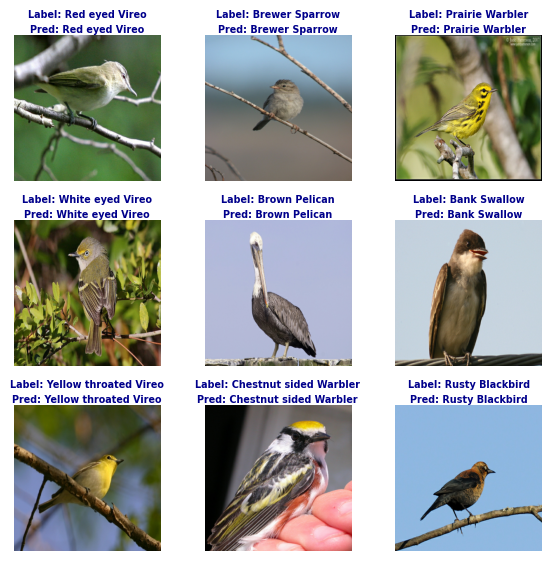

In [ ]:
show_images(images_test, labels_test, labels_test_pred, num_examples=9)

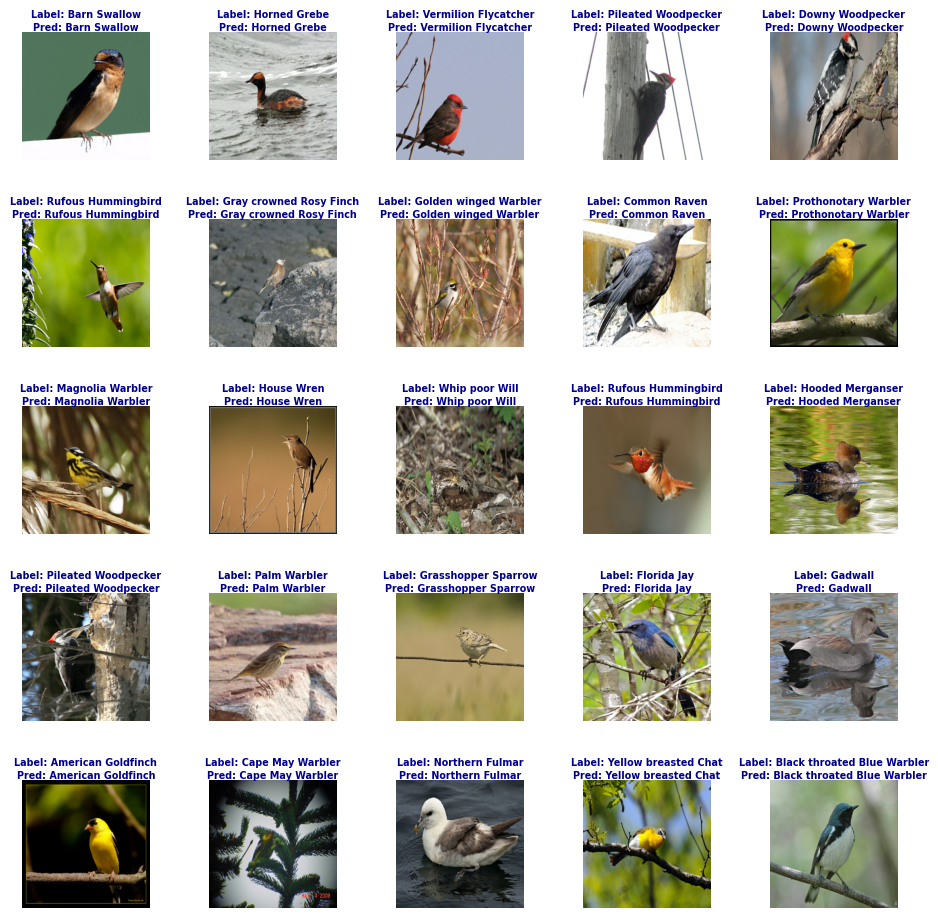

In [ ]:
show_images(
    images_test, labels_test, labels_test_pred, save=True,
    num_examples=25, path="ImageClassification_ConvNeXTV2_CUB-200-2011.png"
)

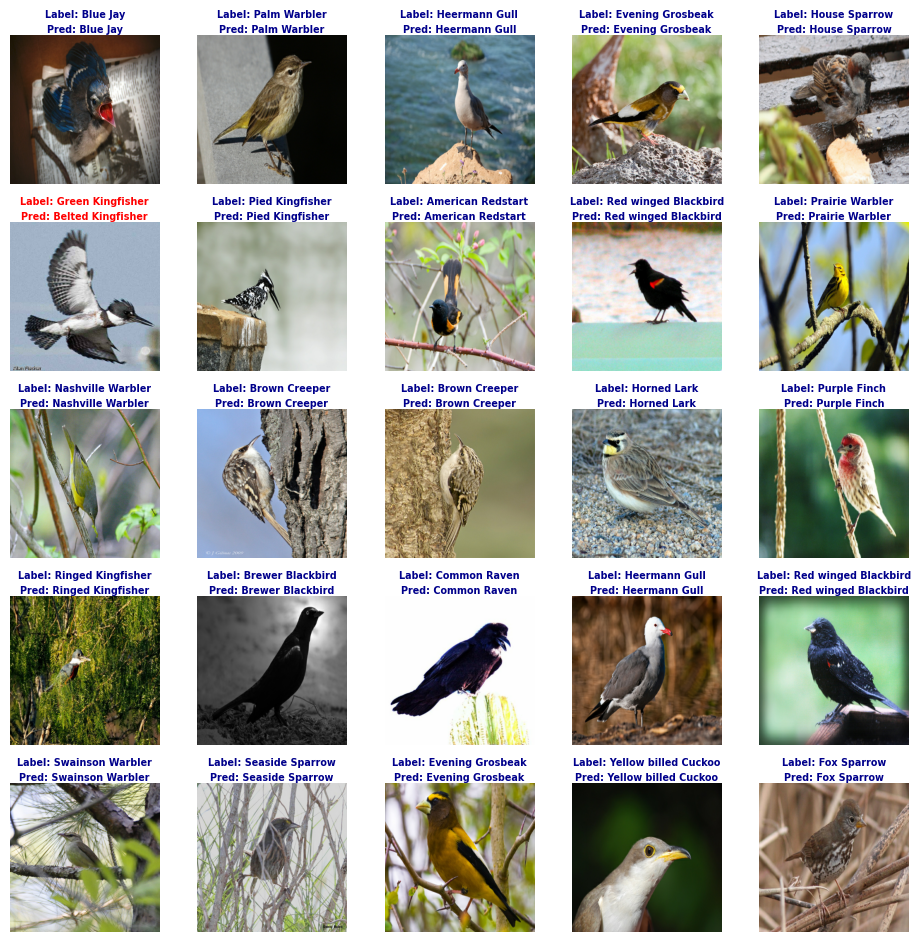

In [ ]:
show_images(images_test, labels_test, labels_test_pred, num_examples=25)

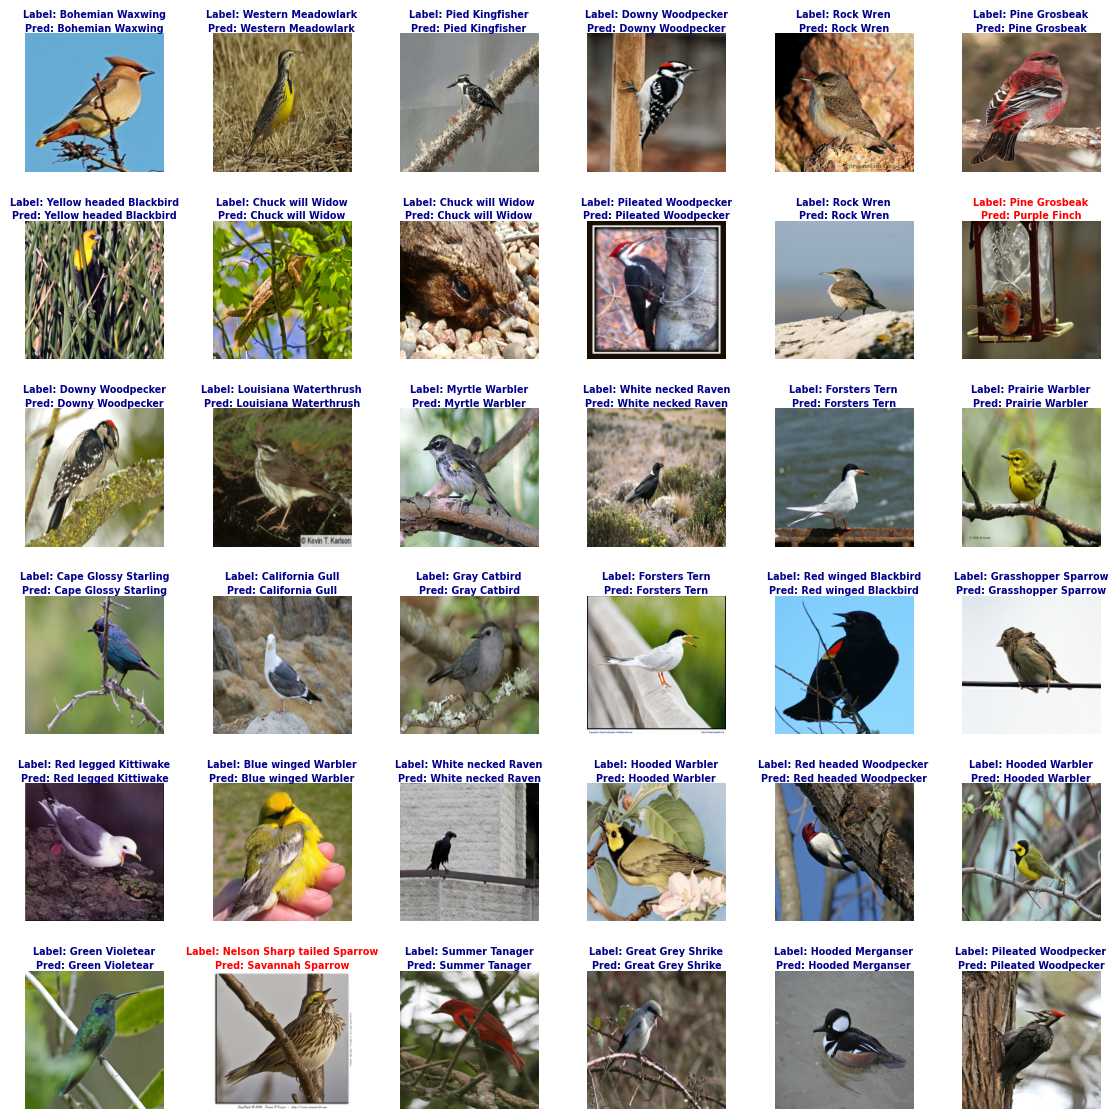

In [ ]:
show_images(images_test, labels_test, labels_test_pred, num_examples=36)

### **Other images**

In [ ]:
# Load the trained model
tf.keras.backend.clear_session()
model = TFAutoModelForImageClassification.from_pretrained(trained_model_path)

All model checkpoint layers were used when initializing TFConvNextV2ForImageClassification.

All the layers of TFConvNextV2ForImageClassification were initialized from the model checkpoint at /content/drive/MyDrive/models/Fine-Grained_ImageClassification_ConvNeXTV2_CUB-200-2011.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFConvNextV2ForImageClassification for predictions without further training.


In [ ]:
# Function to predict images from the internet
def predict_image(url, label=None):
  path = tf.keras.utils.get_file(origin=url)
  image = tf.keras.utils.load_img(path)
  inputs = image_processor(image, return_tensors="tf")

  pred = model(**inputs).logits
  pred = np.argmax(pred, axis=-1)
  pred = class_names[pred[0]]

  if label is not None:
    color = "#00008B" if label == pred else "red"
    plt.title(f"Label: {label}\nPred: {pred}", color=color)
  else:
    plt.title(f"Pred: {pred}")

  plt.imshow(image)
  plt.axis("off")
  plt.tight_layout();

731434/731434 [==============================] - 1s 1us/step


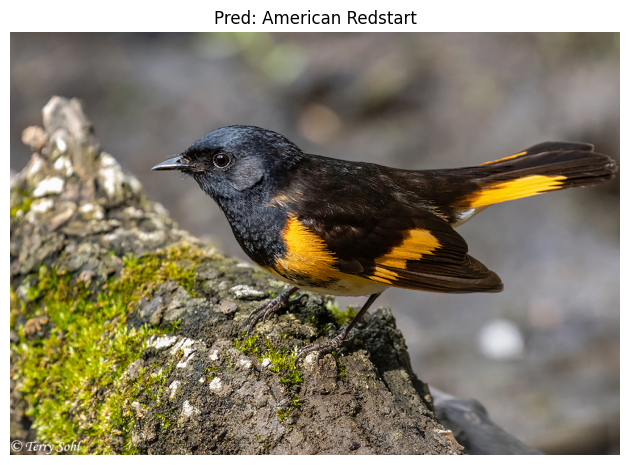

In [ ]:
url = "https://www.sdakotabirds.com/species_photos/warblers/american_redstart_16.jpg"
#label = "American Redstart"

predict_image(url)

107237/107237 [==============================] - 0s 0us/step


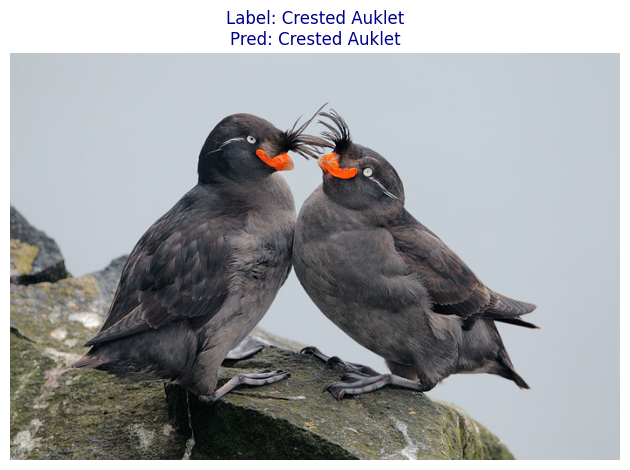

In [ ]:
url = "https://64.media.tumblr.com/a6505cd68cbf41195cb26d9efb20d13d/tumblr_inline_omb9gefMVo1s3cybu_1280.jpg"
label = "Crested Auklet"

predict_image(url, label)

217833/217833 [==============================] - 0s 1us/step


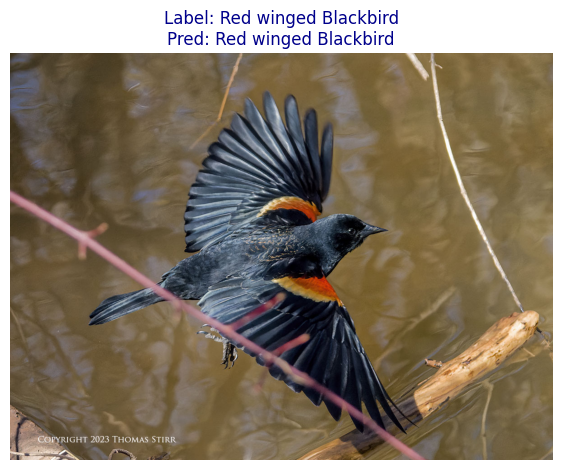

In [ ]:
url = "https://smallsensorphotography.com/wordpress/wp-content/uploads/2023/05/4090193_DxO3909wprocapH1200.jpg"
label = "Red winged Blackbird"

predict_image(url, label)

140449/140449 [==============================] - 0s 0us/step


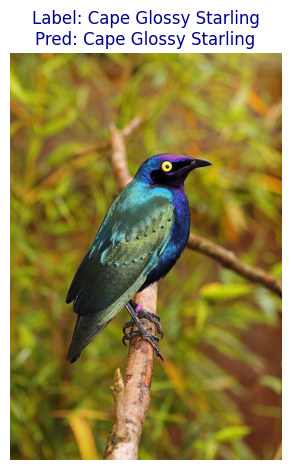

In [ ]:
url = "https://media01.stockfood.com/largepreviews/MjIwMjU5MTU0MA==/71051340-Cape-Starling-Cape-Glossy-Starling-Lamprotornis-nitens-a-species-of-starling-in-the-Sturnidae-family-South.jpg"
label = "Cape Glossy Starling"

predict_image(url, label)

73736/73736 [==============================] - 0s 0us/step


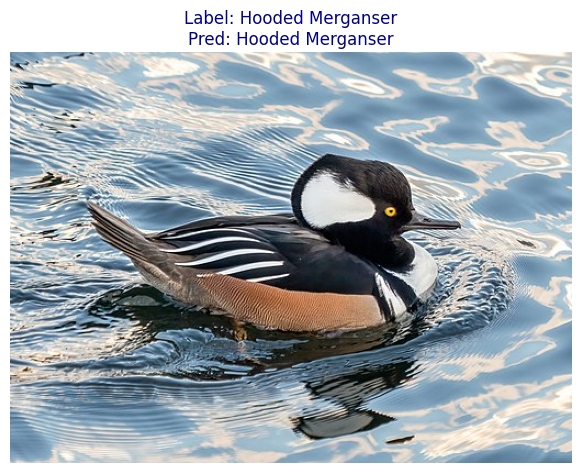

In [ ]:
url = "https://upload.wikimedia.org/wikipedia/commons/thumb/7/70/Hooded_merganser_male_in_Central_Park_%2895790%29.jpg/512px-Hooded_merganser_male_in_Central_Park_%2895790%29.jpg"
label = "Hooded Merganser"

predict_image(url, label)

   8192/Unknown - 0s 0us/step

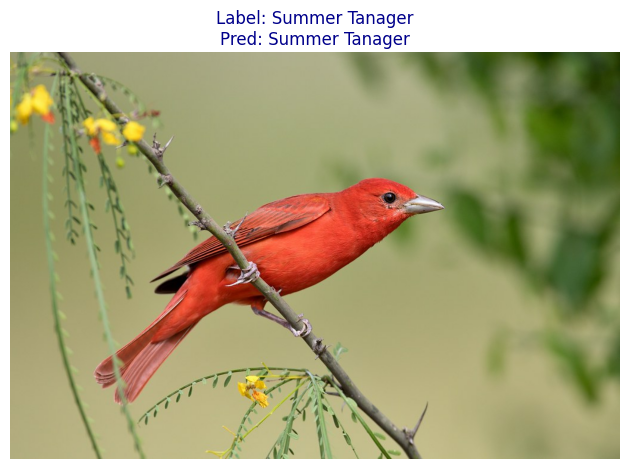

In [ ]:
url = "https://live.staticflickr.com/65535/47057120154_e3fa046c41_b.jpg"
label = "Summer Tanager"

predict_image(url, label)

469389/469389 [==============================] - 1s 1us/step


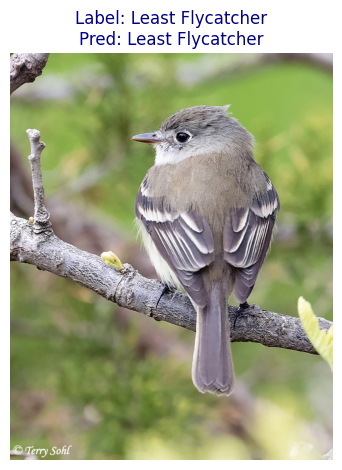

In [ ]:
url = "https://www.sdakotabirds.com/species_photos/flycatchers/least_flycatcher_8.jpg"
label = "Least Flycatcher"

predict_image(url, label)

**Conclusion:** The model achieved an accuracy of **99.55%** on the training dataset and an accuracy of **91.65%** along with an F1 score of **91.57%** on the test dataset. These results demonstrate that the model is effective at classifying images from the CUB-200-2011 dataset as well as images outside this dataset, such as those from the internet, as seen in the predictions section. The slight discrepancy between accuracy and F1 score on the test dataset is due to the model performing better on some bird species compared to others, along with the test dataset being imbalanced. However, the model maintains a good balance between precision and recall despite the challenge posed by the large number of classes and the very limited number of images available for fine-tuning the ConvNeXt V2 Large model.

Despite the use of data augmentation techniques, overfitting is observed, which can be attributed to the small size of the training dataset, consisting of only 5994 images spread across 200 classes. If training had continued for more epochs, it is likely that the accuracy on the training dataset would have reached 100%, while accuracy on the test dataset might have begun to decrease or stabilize.

With an accuracy of **91.65%** on the test dataset, the fine-tuned model is very close to matching MetaFormer, which currently holds the best results on the CUB-200-2011 dataset with an accuracy of **92.9%**, according to [Papers With Code](https://paperswithcode.com/sota/fine-grained-image-classification-on-cub-200). This highlights the robustness of the ConvNeXt V2 model and the effectiveness of the fine-tuning performed in this notebook, despite only using images for model fine-tuning for fine-grained image classification, in contrast to other models like MetaFormer that also utilized additional information (metadata) beyond images for training.